In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from source.datasets import CatBallDataset, AnalogBits, custom_collate_with_info
import numpy as np
import jlc
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('./source/')
from source.utils import write_args, model_and_diffusion_defaults, SmartParser
from argparse import Namespace
args = SmartParser().get_args(do_parse_args=False)
print(args)
#write_args(args, "./saves/test/args.json")
args.ema_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Namespace(attention_resolutions='-2,-1', bce_loss=False, betas='0.9,0.999', cat_ball_data=False, clip_denoised=True, conditioning_type='none', datasets='non-medical', datasets_as_classes=False, deeper_net=True, dropout=0.0, ema_rate='0.9999', eval_batch_size=0, eval_ema_step=50000, eval_guidance_weight=0.0, eval_interval=5000, eval_num_steps=100, fp16_scale_growth=0.001, gamma_clip_min=1e-09, image_size=32, input_scale=1.0, log_train_metrics='loss', log_vali_interval=200, logs_folder='../logs2/', loss_weights='uniform', lr=0.0001, lr_decay_steps=0, lr_decay_type='linear', lr_warmup_steps=0, lr_warmup_type='linear', major_vote_number=5, max_iter=100000, max_num_classes=8, min_label_size=0.01, model_name='test', model_str='model*', no_diffusion=False, no_image_prob=0.1, no_label_prob=0.1, noise_schedule='linear', num_channels=64, num_classes=0, num_heads=4, num_heads_upsample=-1, num_res_blocks=3, num

'0.9999'

In [2]:
filename = r"C:\Users\Janus\Desktop\diff\diffusion2\source\asdasg.png"

import os
print(filename)
print(os.path.dirname(filename))

C:\Users\Janus\Desktop\diff\diffusion2\source\asdasg.png
C:\Users\Janus\Desktop\diff\diffusion2\source


SystemError: tile cannot extend outside image

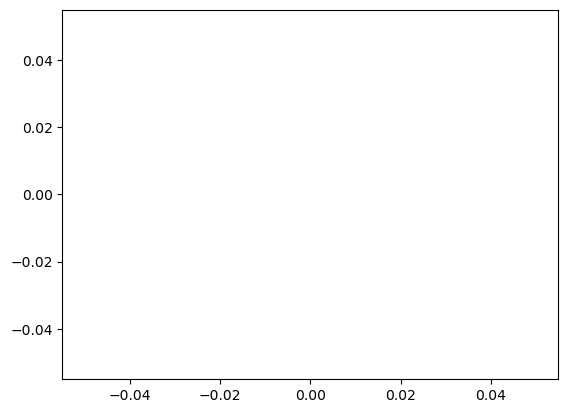

<Figure size 100x0 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
filename = "test.png"

#make empty plot where only x axis takes up space
plt.plot([])
plt.set
plt.savefig(filename)

im = np.array(Image.open(filename))
print(im.shape)

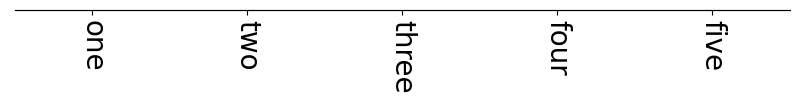

(103, 799, 4)


<Figure size 640x480 with 0 Axes>

In [90]:

def render_axis(h=100,n=5,text=[],angle=0,rotation=None, fontsize=None):
    fig, ax = plt.subplots(figsize=(10,1e-15))
    #ax.set_frame_on(False)
    plt.yticks([])
    plt.xlim(0, n)
    x_pos = np.linspace(0.5,n-0.5,n)
    plt.xticks(x_pos, text, rotation=rotation, fontsize=fontsize)
    plt.show()
    plt.savefig('test2.png', bbox_inches='tight',pad_inches = 0)
    im = np.array(fig.canvas.renderer.buffer_rgba())
    #crop away empty space in each axis

    return im
im = render_axis(text=["one","two","three","four","five"],fontsize=20, rotation=270)
print(im.shape)